# **Problema 3**

En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.


El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:

*   buildings

*   forest

*   glacier

*   mountain

*   sea

*   street

Las imágenes están divididas en tres conjuntos:


*   Train: Alrededor de 14,000 imágenes para entrenamiento.

*   Test: Alrededor de 3,000 imágenes para evaluación del modelo.

*   Prediction: Alrededor de 7,000 imágenes para predicción final.

**Objetivo:**

Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.

Los modelos a diseñar son:

*   Modelo con capas densas.
*   Modelo con capas convolucionales y densas.
*   Modelo que incluya bloques residuales identidad.
*   Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow


Comenzaremos analizando que imágenes tenemos en el dataset.

In [1]:
!pip install gdown

In [2]:
import os
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile
import gdown

In [3]:
file_id = '1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ'
output = '/content/dataset.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

print("Dataset descomprimido.")

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=b4bc92af-feb7-420c-8147-fd752f2fc8d1
To: /content/dataset.zip
100%|██████████| 363M/363M [00:06<00:00, 56.3MB/s]


Dataset descomprimido.


In [130]:
train_dir = '/content/dataset/seg_train/seg_train'
test_dir = '/content/dataset/seg_test/seg_test'
prediction_dir = '/content/dataset/seg_pred/seg_pred'

print(f"Categorías en train: {os.listdir(train_dir)}")
print(f"Categorías en test: {os.listdir(test_dir)}")

Categorías en train: ['mountain', 'glacier', 'sea', 'street', 'buildings', 'forest']
Categorías en test: ['mountain', 'glacier', 'sea', 'street', 'buildings', 'forest']
Categorías en prediction: ['18859.jpg', '6069.jpg', '17950.jpg', '3242.jpg', '24151.jpg', '15686.jpg', '13260.jpg', '9738.jpg', '5991.jpg', '2246.jpg', '7089.jpg', '13936.jpg', '20681.jpg', '22404.jpg', '9122.jpg', '20244.jpg', '17132.jpg', '3823.jpg', '18869.jpg', '22548.jpg', '11890.jpg', '13345.jpg', '7371.jpg', '4519.jpg', '199.jpg', '5499.jpg', '161.jpg', '20865.jpg', '5481.jpg', '8654.jpg', '20920.jpg', '13558.jpg', '23170.jpg', '4724.jpg', '2207.jpg', '8823.jpg', '2861.jpg', '12683.jpg', '24054.jpg', '16883.jpg', '8330.jpg', '9920.jpg', '10405.jpg', '22052.jpg', '14522.jpg', '13663.jpg', '9178.jpg', '3112.jpg', '2135.jpg', '11651.jpg', '11005.jpg', '70.jpg', '14614.jpg', '16546.jpg', '14679.jpg', '3080.jpg', '6521.jpg', '10282.jpg', '7925.jpg', '18278.jpg', '22749.jpg', '12626.jpg', '575.jpg', '7729.jpg', '22499.

Vamos a contar cuantas imágenes hay en cada tipo de dato para ver si esta balanceado el dataset.

Categoría: mountain, Cantidad de imágenes: 525
Categoría: glacier, Cantidad de imágenes: 553
Categoría: sea, Cantidad de imágenes: 510
Categoría: street, Cantidad de imágenes: 501
Categoría: buildings, Cantidad de imágenes: 437
Categoría: forest, Cantidad de imágenes: 474


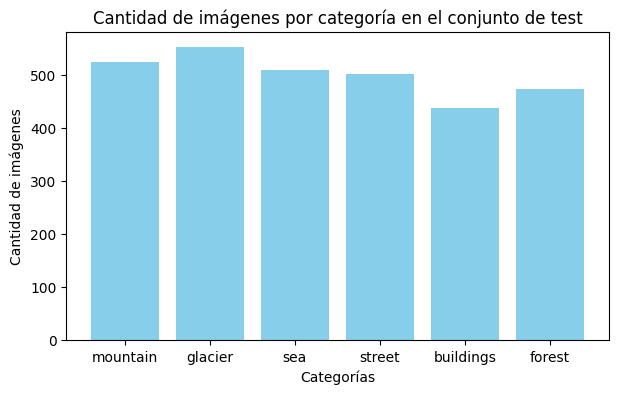

In [96]:
categories = os.listdir(test_dir)
image_count_per_category = {}

for category in categories:
    category_path = os.path.join(test_dir, category)
    image_count_per_category[category] = len(os.listdir(category_path))

for category, count in image_count_per_category.items():
    print(f"Categoría: {category}, Cantidad de imágenes: {count}")

plt.figure(figsize=(7,4))
plt.bar(image_count_per_category.keys(), image_count_per_category.values(), color='skyblue')
plt.title('Cantidad de imágenes por categoría en el conjunto de test')
plt.xlabel('Categorías')
plt.ylabel('Cantidad de imágenes')
plt.xticks()
plt.show()

Categoría: mountain, Cantidad de imágenes: 2512
Categoría: glacier, Cantidad de imágenes: 2404
Categoría: sea, Cantidad de imágenes: 2274
Categoría: street, Cantidad de imágenes: 2382
Categoría: buildings, Cantidad de imágenes: 2191
Categoría: forest, Cantidad de imágenes: 2271


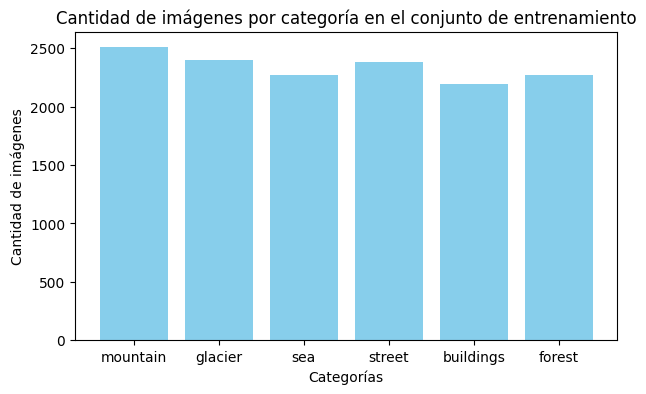

In [5]:
categories = os.listdir(train_dir)
image_count_per_category = {}

for category in categories:
    category_path = os.path.join(train_dir, category)
    image_count_per_category[category] = len(os.listdir(category_path))

for category, count in image_count_per_category.items():
    print(f"Categoría: {category}, Cantidad de imágenes: {count}")

plt.figure(figsize=(7,4))
plt.bar(image_count_per_category.keys(), image_count_per_category.values(), color='skyblue')
plt.title('Cantidad de imágenes por categoría en el conjunto de entrenamiento')
plt.xlabel('Categorías')
plt.ylabel('Cantidad de imágenes')
plt.xticks()
plt.show()

Esta balanceado, no nos preocuparemos por esto.

In [6]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error,mean_absolute_percentage_error



Visualizamos algunas imágenes y su categoría.

In [131]:
tamaño_lote = 64

altura_imagen = 128
anchura_imagen = 128

ds_entrenamiento = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    seed=123,
    image_size=(altura_imagen, anchura_imagen),
    batch_size=tamaño_lote
    )

ds_prueba = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    seed=123,
    image_size=(altura_imagen, anchura_imagen),
    batch_size=tamaño_lote
    )


nombres_clases = ds_entrenamiento.class_names
num_clases = len(nombres_clases)
print(nombres_clases)

plt.figure(figsize=(10, 10))
for imagenes, etiquetas in ds_entrenamiento.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imagenes[i].numpy().astype("uint8"))
    indice_clase = list(etiquetas[i]).index(1)
    plt.title(nombres_clases[indice_clase])
    plt.axis("off")

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 0 files belonging to 0 classes.


ValueError: No images found in directory /content/dataset/seg_pred/seg_pred. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [8]:
!pip install keras
!pip install tensorflow

## Modelo con capas densas


In [9]:
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout, Add
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model

In [10]:
import tensorflow as tf

In [11]:
input_shape = (128, 128, 3)
num_classes = 6

Elaboramos el modelo

In [148]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="reflect"),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(num_classes),
    tf.keras.layers.Activation("softmax")
])


Usamos rescaling, porque normaliza los valores de píxeles de las imágenes dividiendo por 255. RandomFlip voltea aleatoriamente horizontal y vertical a las imágenes. Con randomTranslation desplazo un 10% del tamaño de la imagen en ambas direcciones. Y por último, con randomContrast modifico el contraste de las imágenes.

In [149]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', tf.keras.metrics.Recall()])


In [150]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_12 (RandomFlip)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_13 (RandomFlip)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_6                 │ (None, 128, 128, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_6 (RandomContrast)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 90)                  │       4,423,770 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 90)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 70)                  │           6,370 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 30)                  │           2,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 6)                   │             126 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 6)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,433,016 (16.91 MB)

 Trainable params: 4,433,016 (16.91 MB)

 Non-trainable params: 0 (0.00 B)

In [151]:
history = model.fit(
    ds_entrenamiento,
    validation_data=ds_prueba,
    epochs=25,
    batch_size=64
)

Epoch 1/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.2313 - loss: 2.1134 - recall_3: 0.0338 - val_accuracy: 0.3960 - val_loss: 1.6044 - val_recall_3: 0.0087
Epoch 2/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.3071 - loss: 1.6397 - recall_3: 0.0287 - val_accuracy: 0.3350 - val_loss: 1.5751 - val_recall_3: 0.0843
Epoch 3/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.3239 - loss: 1.6073 - recall_3: 0.0388 - val_accuracy: 0.3783 - val_loss: 1.4980 - val_recall_3: 0.0533
Epoch 4/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.3336 - loss: 1.5780 - recall_3: 0.0412 - val_accuracy: 0.3470 - val_loss: 1.5335 - val_recall_3: 0.0140
Epoch 5/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.3386 - loss: 1.5728 - recall_3: 0.0383 - val_accuracy: 0.3783 - val_loss: 1.4865 - val_recall_3: 0.1287
Epoch 6/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.3552 - loss: 1.5493 - recall_3: 0.1186 - val_accuracy: 0.3867 - val_loss:

Precisión: siendo el porcentaje de predicciones correctas sobre el total de predicciones, tenemos valores que aumentan en cada época, logrando valores que no son muy buenos.

Loss: dismimunye a lo largo de las épocas.

Recall:  capacidad para identificar correctamente las instancias positivas. Aumenta pero no logra buenos resultados.

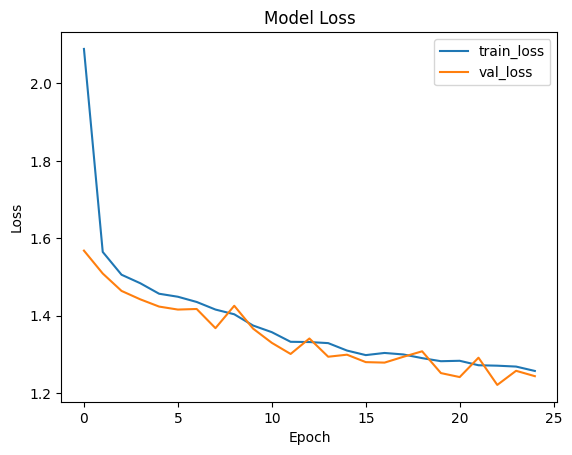

In [16]:
loss = history.history['loss']

plt.plot(loss, label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Observamos una disminución de la pérdida tanto en el conjunto de entrenamiento como en el de validación a medida que pasan las épocas. Sugiriendo que el modelo está aprendiendo bien.

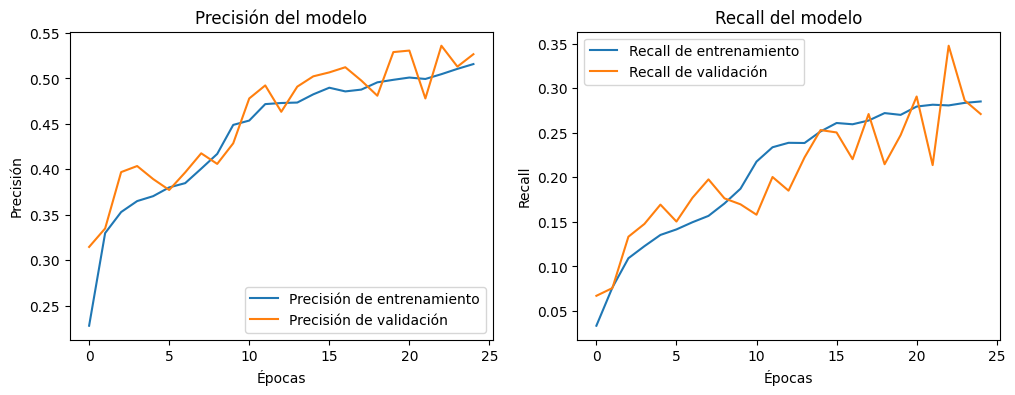

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='Recall de entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

plt.show()

La precisión del entrenamiento y validación mejora con el pasar de las épocas, lo que significa que el modelo está clasificando bien.
Ambas son consistentes entre sí, por ende no está sobreajustado.

El recall funciona muy similar.

In [18]:
final_train_loss1 = history.history['loss'][-1]
final_val_loss1 = history.history['val_loss'][-1]
final_train_accuracy1 = history.history['accuracy'][-1]
final_val_accuracy1 = history.history['val_accuracy'][-1]
final_train_recall1 = history.history['recall'][-1]
final_val_recall1 = history.history['val_recall'][-1]

print(f"Resultados finales del modelo tras {len(history.epoch)} épocas:")
print(f"- Loss -- entrenamiento: {final_train_loss1:.4f}, ", f" validación: {final_val_loss1:.4f}")
print(f"- Precisión -- entrenamiento: {final_train_accuracy1:.4f}, ", f" validación: {final_val_accuracy1:.4f}")
print(f"- Recall -- entrenamiento: {final_train_recall1:.4f}, ", f" validación: {final_val_recall1:.4f}")

Resultados finales del modelo tras 25 épocas:
- Loss -- entrenamiento: 1.2572,   validación: 1.2437
- Precisión -- entrenamiento: 0.5158,   validación: 0.5267
- Recall -- entrenamiento: 0.2851,   validación: 0.2710


Tanto el loss como el recall de entrenamiento es menor que la pérdida de validación, por lo que el modelo se está ajustando bien.

Una precisión superior al 80% se considera aceptable, como es en nuestro caso.

## Modelo con capas convolucionales y densas

In [19]:
from tensorflow.keras.layers import LeakyReLU

Vamos a elaborar el modelo combinando capas convolucionales y densas.

In [20]:
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)
    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (5, 5))(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(16, (5, 5))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (5, 5))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (5, 5))(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (5, 5))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [136]:
model_conv_dense = build_model((128, 128, 3), 6)

model_conv_dense.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Vamos a usar Early Stopping que frena el entrenamiento cuando no se ve mejora en el rendimiento en validación durante un número de épocas.

In [137]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, verbose=1, mode="min") # Frena cuando el val_loss deje de disminuir

history = model_conv_dense.fit(
    ds_entrenamiento,
    validation_data=ds_prueba,
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.4081 - loss: 1.3845 - recall: 0.1605 - val_accuracy: 0.5813 - val_loss: 1.0702 - val_recall: 0.3733
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.5955 - loss: 1.0047 - recall: 0.4260 - val_accuracy: 0.6220 - val_loss: 0.9207 - val_recall: 0.5363
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.6742 - loss: 0.8442 - recall: 0.5830 - val_accuracy: 0.6660 - val_loss: 0.9361 - val_recall: 0.5987
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.7030 - loss: 0.7755 - recall: 0.6310 - val_accuracy: 0.7407 - val_loss: 0.6967 - val_recall: 0.6650
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.7359 - loss: 0.6991 - recall: 0.6781 - val_accuracy: 0.6857 - val_loss: 0.8274 - val_recall: 0.6483
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.7298 - loss: 0.6964 - recall: 0.6766 - val_accuracy: 0.7480 - val_loss: 0.7110 - val_recall:

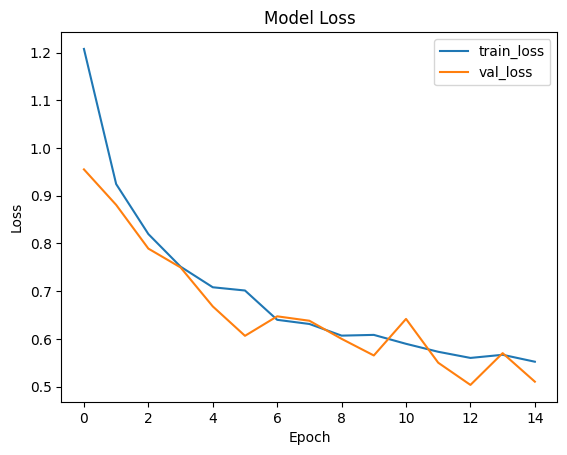

In [23]:
loss = history.history['loss']

plt.plot(loss, label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

La variación en el eje y es menor, por lo que los picos que observamos no nos alertan.

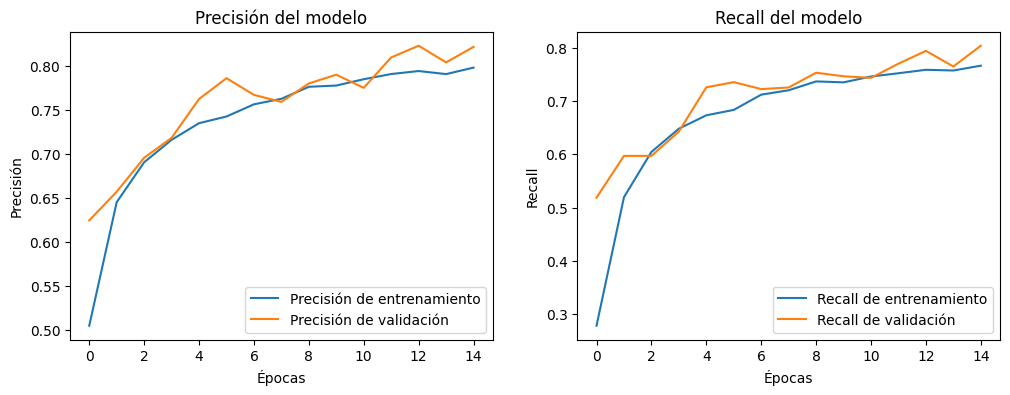

In [24]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='Recall de entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

plt.show()

Al igual que el modelo anterior, tanto precisión como recall mejoran con las épocas y son muy similares.

In [25]:
final_train_loss2 = history.history['loss'][-1]
final_val_loss2 = history.history['val_loss'][-1]
final_train_accuracy2 = history.history['accuracy'][-1]
final_val_accuracy2 = history.history['val_accuracy'][-1]
final_train_recall2 = history.history['recall'][-1]
final_val_recall2 = history.history['val_recall'][-1]

print(f"Resultados finales del modelo tras {len(history.epoch)} épocas:")
print(f"- Loss -- entrenamiento: {final_train_loss2:.4f}, ", f" validación: {final_val_loss2:.4f}")
print(f"- Precisión -- entrenamiento: {final_train_accuracy2:.4f}, ", f" validación: {final_val_accuracy2:.4f}")
print(f"- Recall -- entrenamiento: {final_train_recall2:.4f}, ", f" validación: {final_val_recall2:.4f}")

Resultados finales del modelo tras 15 épocas:
- Loss -- entrenamiento: 0.5520,   validación: 0.5102
- Precisión -- entrenamiento: 0.7984,   validación: 0.8220
- Recall -- entrenamiento: 0.7662,   validación: 0.8037


## Modelo que incluye bloques residuales identidad

In [26]:
from tensorflow.keras.layers import BatchNormalization, Add, Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation
from tensorflow.keras.models import Model


Entrada: Se recibe la salida de la capa anterior y el número de filtros.

Convoluciones: Se aplican dos capas de convolución, cada una seguida de normalización por lotes, para estabilidad y la velocidad de entrenamiento, y activación ReLU.

Shortcut Connection: Se utiliza una conexión de atajo que permite que la entrada original se sume a la salida de las convoluciones. Esto ayuda a disminuir el problema de la desaparición del gradiente.

Salida: La suma de la salida convolucionada y la conexión de atajo que pasa a través de otra activación ReLU.

In [27]:
def residual_block(x, filters, kernel_size=(3, 3)):
    shortcut = x

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    shortcut = Conv2D(filters, (1, 1))(shortcut)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)

    return x

In [28]:
def build_resnet_model(input_shape, output_labels):
  i = Input(input_shape, dtype=tf.float32)
  x = Rescaling(1./255)(i)
  x = RandomFlip("horizontal")(x)
  x = RandomFlip("vertical")(x)
  x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
  x = RandomContrast(0.2)(x)

  # Bloque convolucional inicial
  x = Conv2D(8, (3, 3))(x)
  x = Activation("relu")(x)
  x = Dropout(0.3)(x)
  x = MaxPooling2D((2, 2))(x)

  # Bloques residuales
  x = residual_block(x, 16)
  x = MaxPooling2D((2, 2))(x)
  x = residual_block(x, 32)
  x = MaxPooling2D((2, 2))(x)
  x = residual_block(x, 64)
  x = MaxPooling2D((2, 2))(x)
  x = residual_block(x, 64)
  x = MaxPooling2D((2, 2))(x)
  x = residual_block(x, 128)
  x = MaxPooling2D((2, 2))(x)

  # Capa de salida
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = Dense(output_labels)(x)
  x = Activation("softmax")(x)

  return tf.keras.Model(inputs=[i], outputs=[x])

In [29]:
model_residual = build_resnet_model((128, 128, 3), 6)

model_residual.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

In [30]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, verbose=1, mode="min") # Frena cuando el val_loss deje de disminuir

history = model_residual.fit(
    ds_entrenamiento,
    validation_data=ds_prueba,
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.4671 - loss: 1.4466 - recall: 0.3450 - val_accuracy: 0.1710 - val_loss: 3.3151 - val_recall: 0.1700
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.6442 - loss: 0.9114 - recall: 0.5595 - val_accuracy: 0.3680 - val_loss: 1.6474 - val_recall: 0.3043
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.7033 - loss: 0.7965 - recall: 0.6354 - val_accuracy: 0.4710 - val_loss: 1.6343 - val_recall: 0.4257
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.7508 - loss: 0.6753 - recall: 0.6997 - val_accuracy: 0.6987 - val_loss: 0.8207 - val_recall: 0.6353
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.7673 - loss: 0.6271 - recall: 0.7311 - val_accuracy: 0.7453 - val_loss: 0.6646 - val_recall: 0.6877
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.7833 - loss: 0.6013 - recall: 0.7470 - val_accuracy: 0.6763 - val_loss: 0.9409 - val_recall:

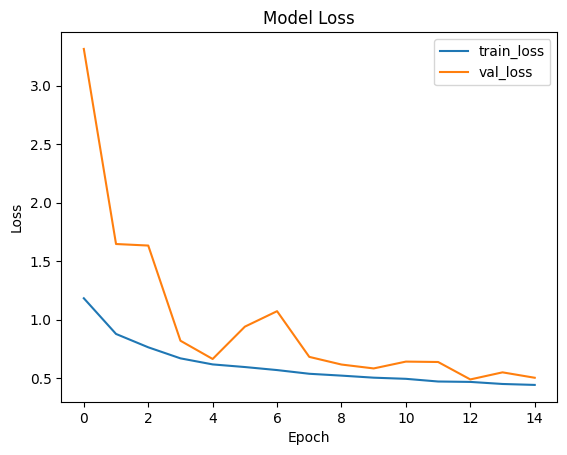

In [31]:
loss = history.history['loss']

plt.plot(loss, label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

En el loss de validación encontramos unos picos que nos llaman la atención.

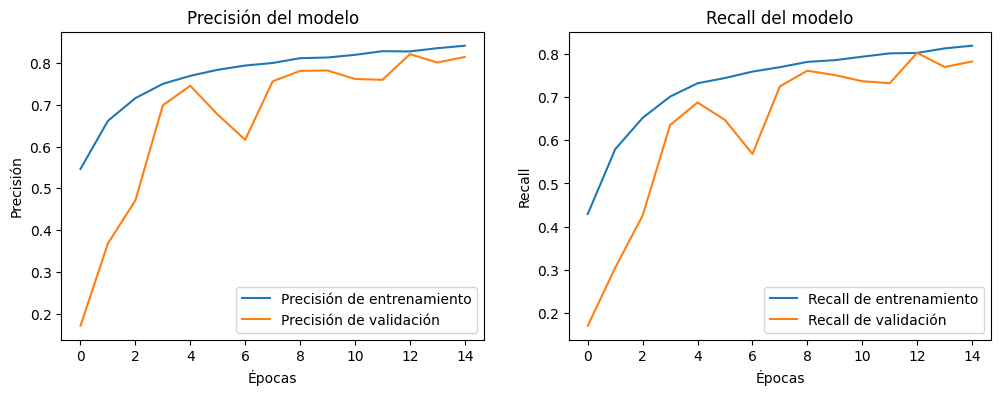

In [32]:
plt.figure(figsize=(12, 4))

# Gráfica de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='Recall de entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

plt.show()


In [33]:
final_train_loss3 = history.history['loss'][-1]
final_val_loss3 = history.history['val_loss'][-1]
final_train_accuracy3 = history.history['accuracy'][-1]
final_val_accuracy3 = history.history['val_accuracy'][-1]
final_train_recall3 = history.history['recall'][-1]
final_val_recall3 = history.history['val_recall'][-1]

print(f"Resultados finales del modelo tras {len(history.epoch)} épocas:")
print(f"- Loss -- entrenamiento: {final_train_loss3:.4f}, ", f" validación: {final_val_loss3:.4f}")
print(f"- Precisión -- entrenamiento: {final_train_accuracy3:.4f}, ", f" validación: {final_val_accuracy3:.4f}")
print(f"- Recall -- entrenamiento: {final_train_recall3:.4f}, ", f" validación: {final_val_recall3:.4f}")

Resultados finales del modelo tras 15 épocas:
- Loss -- entrenamiento: 0.4429,   validación: 0.5041
- Precisión -- entrenamiento: 0.8412,   validación: 0.8143
- Recall -- entrenamiento: 0.8193,   validación: 0.7827


## Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow

In [34]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Usamos Efficient Net porque es la que mejores resultados da.

In [65]:
def build__transfer_learning_model(input_shape, num_classes):
  base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
  #Include_top = false hace que no se agreguen las ultimas capas para poder personalizarlas
  base_model.trainable = False #Para congelar los pesos del modelo base y que actue como extractor de características fijas.


  i = Input(shape=input_shape)
  x = base_model(i, training=False)
  x = GlobalMaxPooling2D()(x)
  x = Dropout(0.6)(x)  #Dropout alto para reducir el overfitting, que es muy alto en este tipo de entrenamientos, llegando a haber grandes diferencias entre validation y train
  x = Dense(num_classes, activation='softmax')(x)

  return tf.keras.Model(i, x)

In [66]:
model_transfer_learning = build__transfer_learning_model((128, 128, 3), num_classes)
model_transfer_learning.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [67]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, verbose=1, mode="min") # Frena cuando el val_loss deje de disminuir

history = model_transfer_learning.fit(
    ds_entrenamiento,
    validation_data=ds_prueba,
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.6010 - loss: 1.6767 - recall: 0.5832 - val_accuracy: 0.8890 - val_loss: 0.3528 - val_recall: 0.8870
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.8268 - loss: 0.5979 - recall: 0.8239 - val_accuracy: 0.8967 - val_loss: 0.3234 - val_recall: 0.8937
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8563 - loss: 0.4674 - recall: 0.8533 - val_accuracy: 0.9000 - val_loss: 0.2936 - val_recall: 0.8977
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.8663 - loss: 0.4138 - recall: 0.8636 - val_accuracy: 0.9013 - val_loss: 0.3094 - val_recall: 0.8973
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8653 - loss: 0.4130 - recall: 0.8627 - val_accuracy: 0.8987 - val_loss: 0.3065 - val_recall: 0.8977
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8682 - loss: 0.4036 - recall: 0.8643 - val_accuracy: 0.8957 - val_loss: 0.3073 - val_recall:

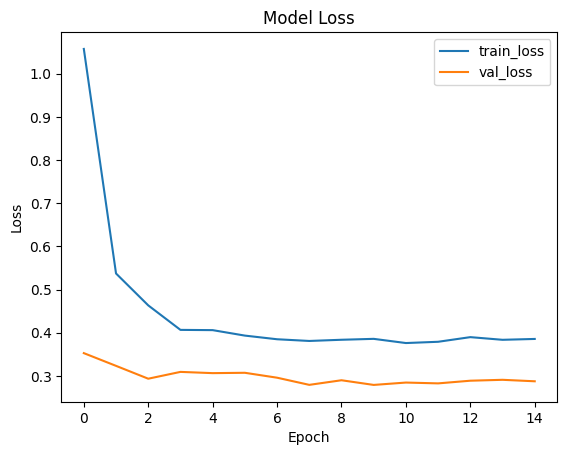

In [68]:
loss = history.history['loss']

plt.plot(loss, label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

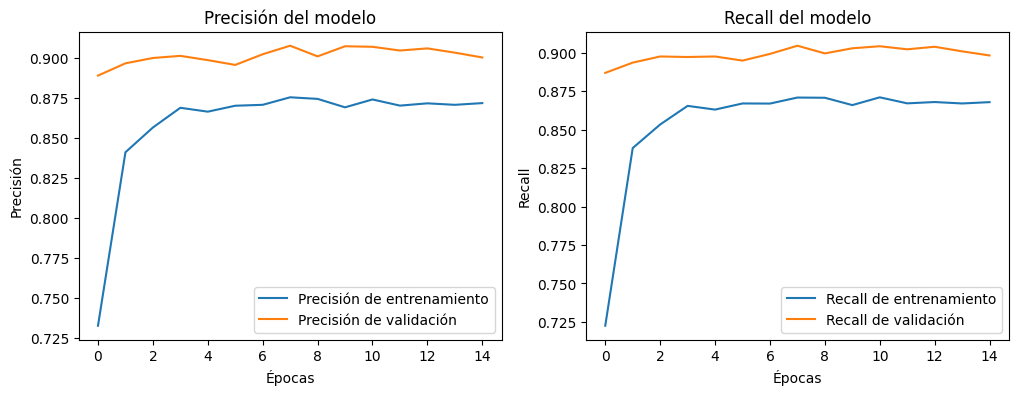

In [69]:
plt.figure(figsize=(12, 4))

# Gráfica de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='Recall de entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

plt.show()


In [70]:
final_train_loss4 = history.history['loss'][-1]
final_val_loss4 = history.history['val_loss'][-1]
final_train_accuracy4 = history.history['accuracy'][-1]
final_val_accuracy4 = history.history['val_accuracy'][-1]
final_train_recall4 = history.history['recall'][-1]
final_val_recall4 = history.history['val_recall'][-1]

print(f"Resultados finales del modelo tras {len(history.epoch)} épocas:")
print(f"- Loss -- entrenamiento: {final_train_loss4:.4f}, ", f" validación: {final_val_loss4:.4f}")
print(f"- Precisión -- entrenamiento: {final_train_accuracy4:.4f}, ", f" validación: {final_val_accuracy4:.4f}")
print(f"- Recall -- entrenamiento: {final_train_recall4:.4f}, ", f" validación: {final_val_recall4:.4f}")

Resultados finales del modelo tras 15 épocas:
- Loss -- entrenamiento: 0.3857,   validación: 0.2876
- Precisión -- entrenamiento: 0.8718,   validación: 0.9003
- Recall -- entrenamiento: 0.8680,   validación: 0.8983


In [76]:
model_results = {
    "Modelo con capas densas": {
        "train_loss": final_train_loss1,
        "val_loss": final_val_loss1,
        "train_accuracy": final_train_accuracy1,
        "val_accuracy": final_val_accuracy1,
        "train_recall": final_train_recall1,
        "val_recall": final_val_recall1,
    },
    "Modelo con densas y convs": {
        "train_loss": final_train_loss2,
        "val_loss": final_val_loss2,
        "train_accuracy": final_train_accuracy2,
        "val_accuracy": final_val_accuracy2,
        "train_recall": final_train_recall2,
        "val_recall": final_val_recall2,
    },
    "Modelo con bloques residuales": {
        "train_loss": final_train_loss3,
        "val_loss": final_val_loss3,
        "train_accuracy": final_train_accuracy3,
        "val_accuracy": final_val_accuracy3,
        "train_recall": final_train_recall3,
        "val_recall": final_val_recall3,
    },
    "Modelo con backbone effective net": {
        "train_loss": final_train_loss4,
        "val_loss": final_val_loss4,
        "train_accuracy": final_train_accuracy4,
        "val_accuracy": final_val_accuracy4,
        "train_recall": final_train_recall4,
        "val_recall": final_val_recall4,
    },
}

# Imprimir el cuadro comparativo
print(f"{'Modelo':<10}              |  {'Train Loss':<12} | {'Val Loss':} | {'Train Accuracy':<12} | {'Val Accuracy':<12} | {'Train Recall':<12} | {'Val Recall':<12}")
print("-" * 100)

for model, results in model_results.items():
    print(f"{model:<10} | {results['train_loss']:.4f}      |  {results['val_loss']:.4f}      | {results['train_accuracy']:.4f}      | {results['val_accuracy']:.4f}      | {results['train_recall']:.4f}      | {results['val_recall']:.4f}")


Modelo                  |  Train Loss   | Val Loss | Train Accuracy | Val Accuracy | Train Recall | Val Recall  
----------------------------------------------------------------------------------------------------
Modelo con capas densas | 1.2572      |  1.2437      | 0.5158      | 0.5267      | 0.2851      | 0.2710
Modelo con densas y convs | 0.5520      |  0.5102      | 0.7984      | 0.8220      | 0.7662      | 0.8037
Modelo con bloques residuales | 0.4429      |  0.5041      | 0.8412      | 0.8143      | 0.8193      | 0.7827
Modelo con backbone effective net | 0.3857      |  0.2876      | 0.8718      | 0.9003      | 0.8680      | 0.8983


In [87]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image

Predicciones para cada modelo

In [132]:
nombres_clases = ds_prueba.class_names
print(nombres_clases)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


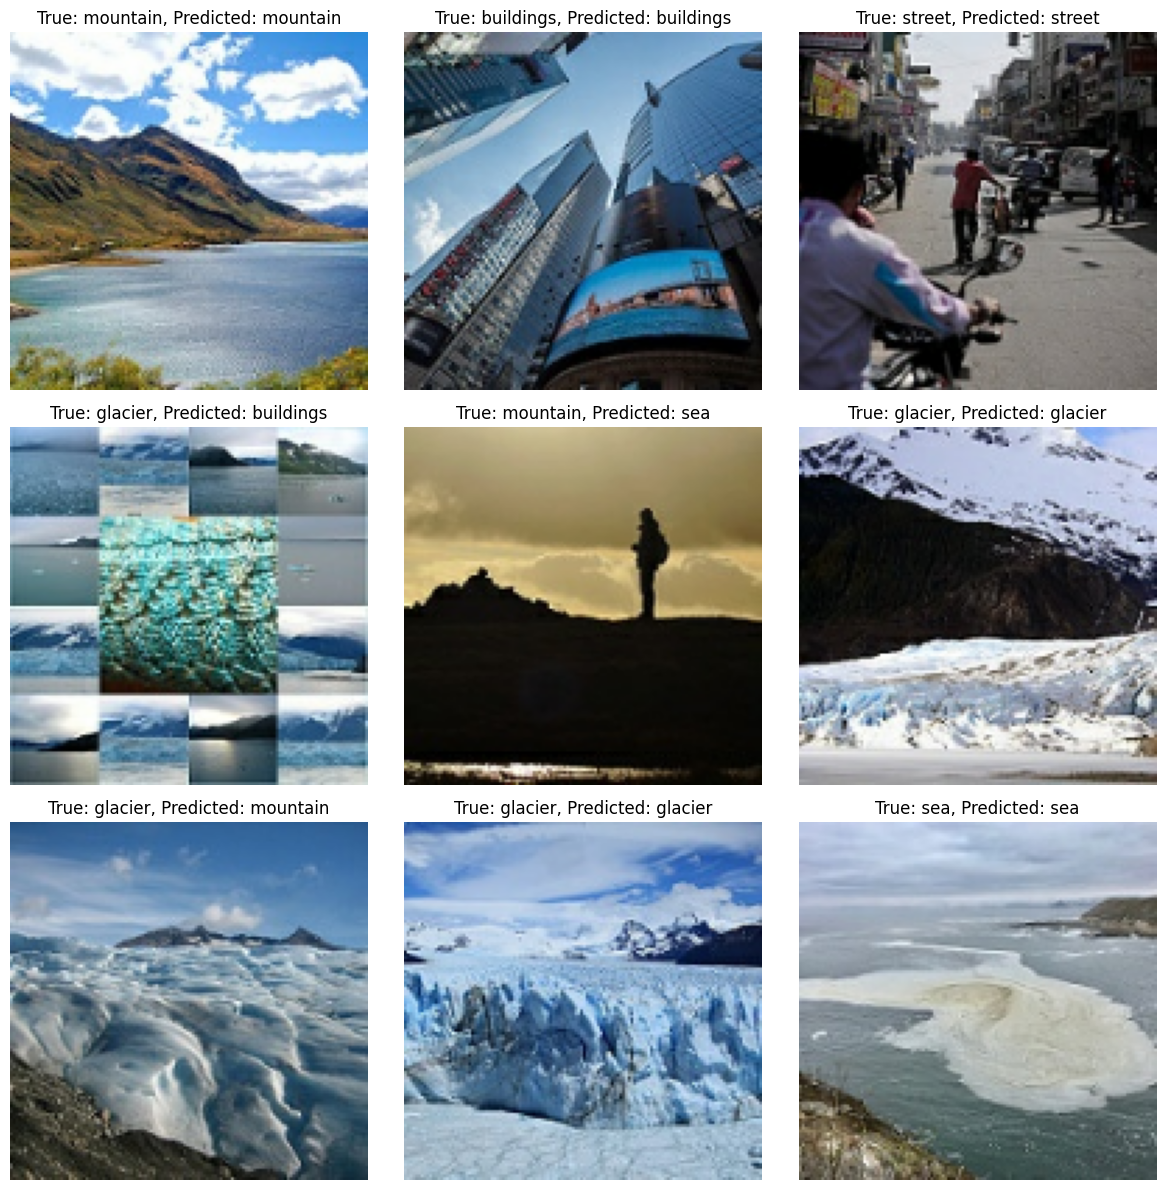

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Función para calcular métricas, mostrar la matriz de confusión y visualizar las predicciones
def show_predictions(model, dataset, num_images=9):
    # Obtiene imágenes y etiquetas verdaderas del conjunto de validación
    images, labels = next(iter(dataset))

    # Realiza predicciones
    predictions = model.predict(images)

    # Obtiene las clases predichas
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    # Visualiza algunas predicciones
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Muestra la imagen
        plt.title(f'True: {nombres_clases[true_classes[i]]}, Predicted: {nombres_clases[predicted_classes[i]]}')  # Muestra las etiquetas
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Llama a la función para calcular las métricas, mostrar la matriz de confusión y visualizar predicciones
show_predictions(model_transfer_learning, ds_prueba)





2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


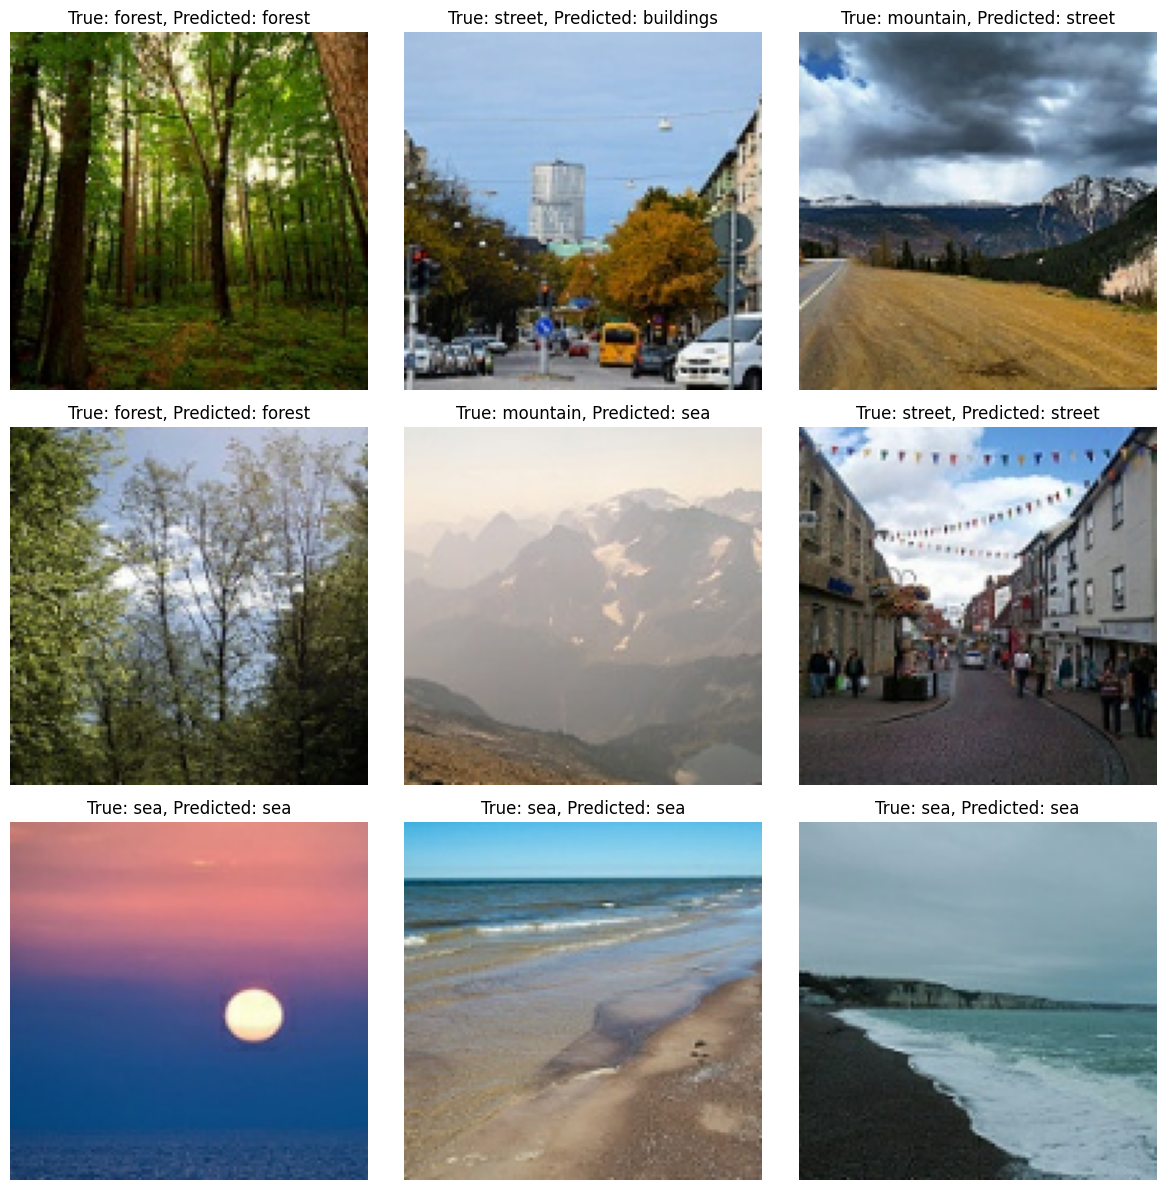

In [135]:
show_predictions(model_residual, ds_prueba)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


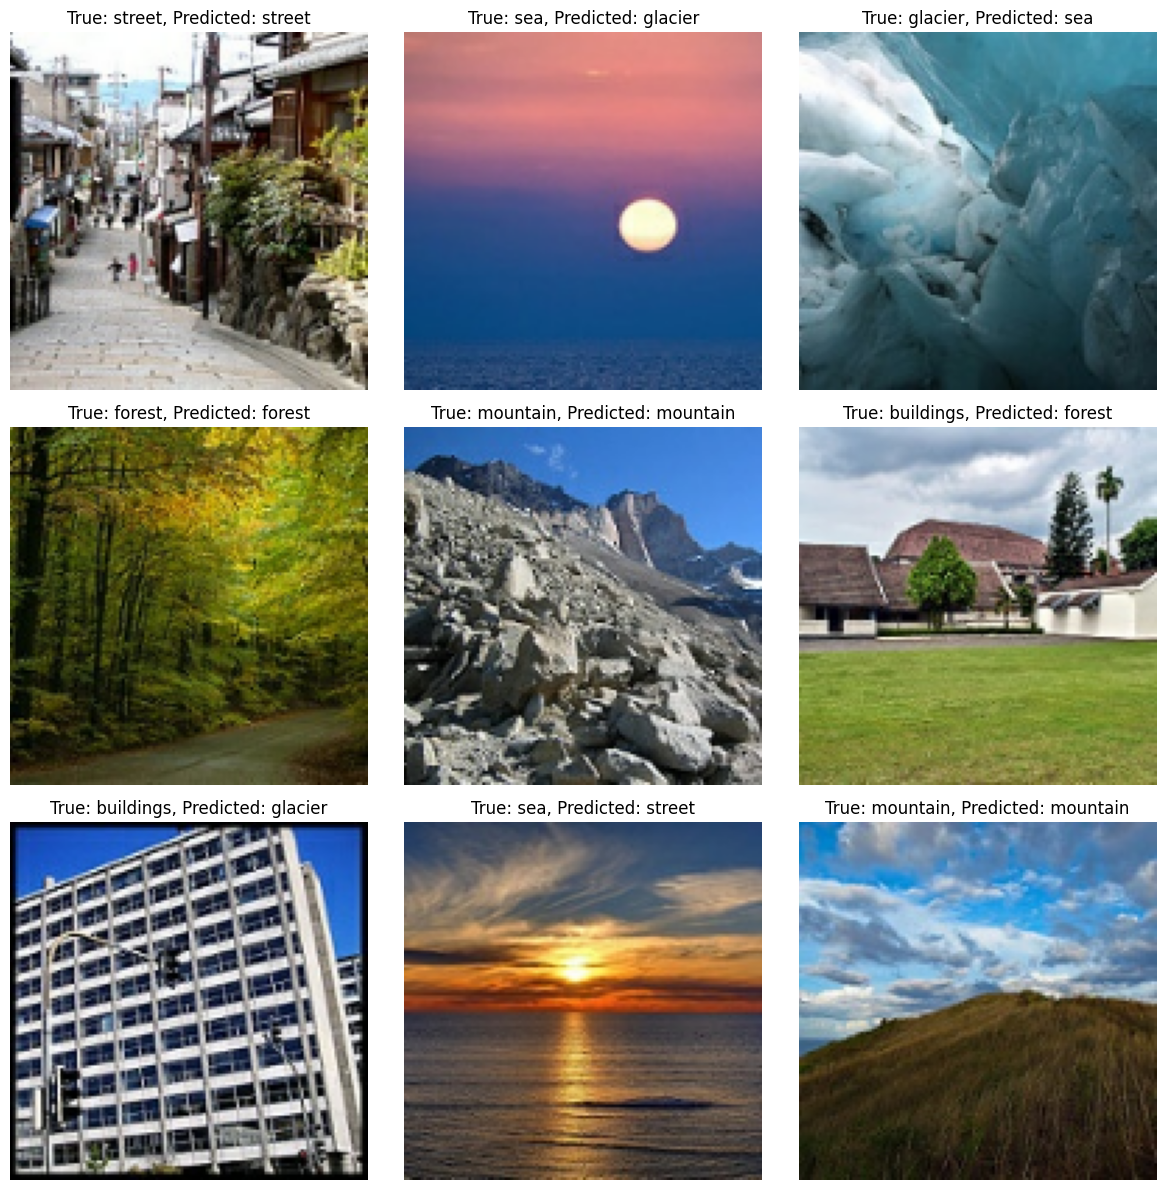

In [152]:
show_predictions(model, ds_prueba)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  


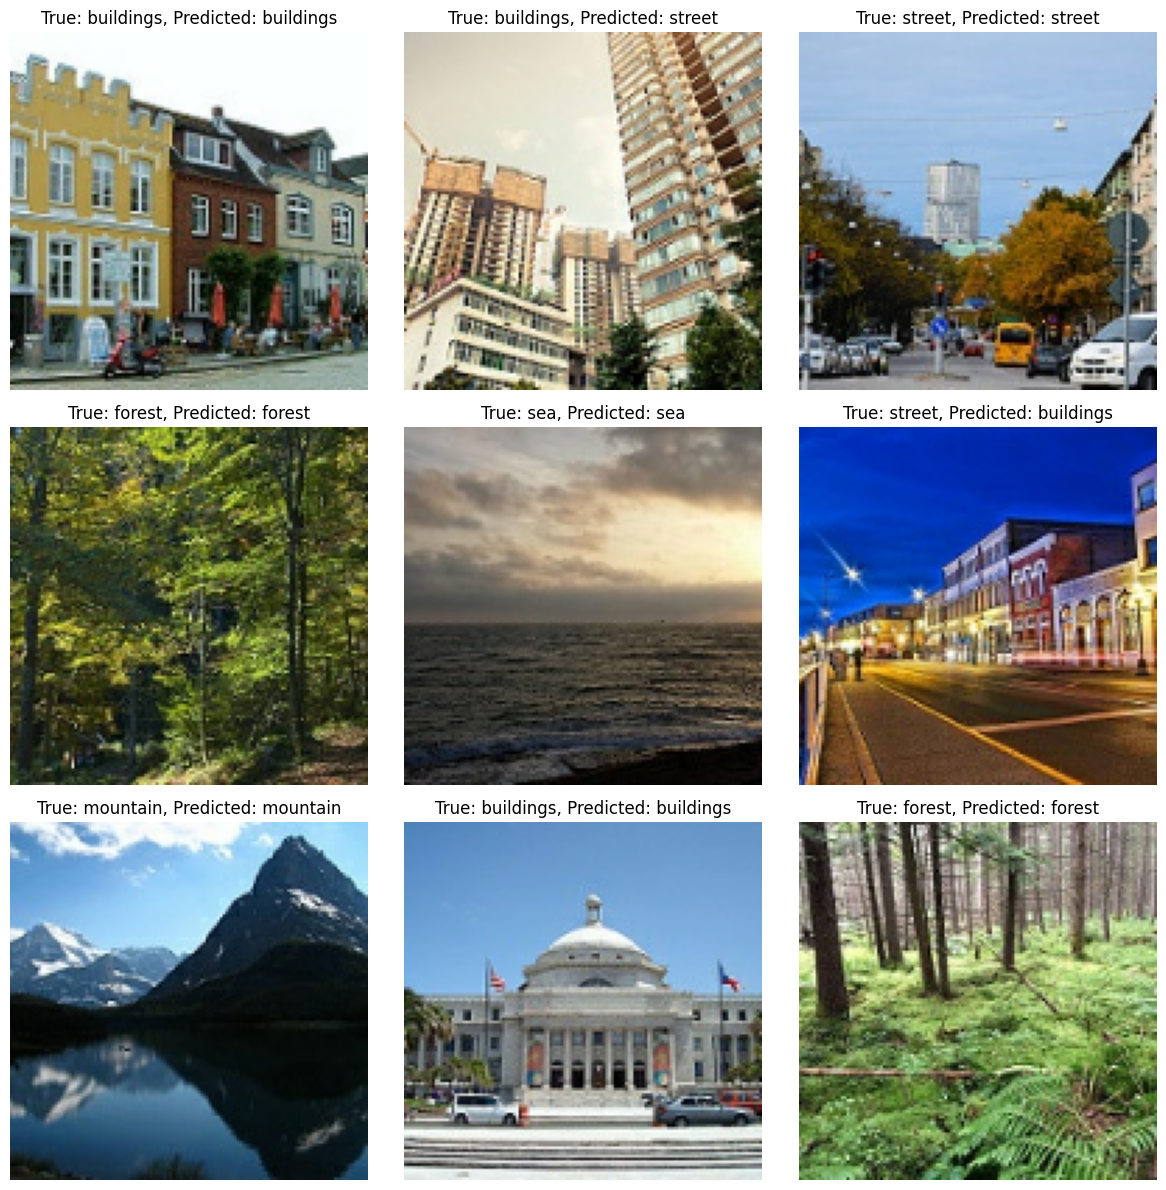

In [139]:
show_predictions(model_conv_dense, ds_prueba)